# Weekend Movie Trip

Dalton Hahn (2762306)

## MovieLens Datasets

MovieLens 20M Dataset

http://files.grouplens.org/datasets/movielens/ml-20m.zip

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statistics import mean, stdev

## Read in the Data

In [2]:
df_gscores = pd.read_csv("../data/external/genome-scores.csv")
df_gscores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [3]:
df_gtags = pd.read_csv("../data/external/genome-tags.csv")
df_gtags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [4]:
df_links = pd.read_csv("../data/external/links.csv")
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
df_movies = pd.read_csv("../data/external/movies.csv")
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
df_ratings = pd.read_csv("../data/external/ratings.csv")
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
df_tags = pd.read_csv("../data/external/tags.csv")
df_tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


## TO-DO List
1. Separate movie title into title and a new column for year (df_movies)
2. Separate movie genres into actual list instead of weird text with bars (19 unique genres - 18 + no genre) (df_movies)
3. Timestamp may not be super relevant (may drop column)
4. Correlate columns that are similar/the same, create one dataframe with all important features
5. Links table almost completely useless, just correlates movies IDs to IMDB IDs and TheMovieDB IDs
6. Genome scores and genome tags can be combined to correlate less formal "tags" with movies that exhibit similar properties

## Data Processing

In [8]:
# 1. Separate movie title into title and year

years = []
titles = []

for row in df_movies["title"]:
    year = row[-5:len(row)-1]
    years.append(year)
    title = row[:]
    titles.append(title)
    
df_movies.insert(len(df_movies.columns), 'Year', years, True)
df_movies.insert(len(df_movies.columns), 'Title', titles, True)
df_movies = df_movies.drop(axis=1, columns='title')

df_movies.head()

,movieId,genres,Year,Title
0,1,Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story (1995)
1,2,Adventure|Children|Fantasy,1995,Jumanji (1995)
2,3,Comedy|Romance,1995,Grumpier Old Men (1995)
3,4,Comedy|Drama|Romance,1995,Waiting to Exhale (1995)
4,5,Comedy,1995,Father of the Bride Part II (1995)


In [9]:
# 2. Separate genres into a true list of genres

genres_full = []

for row in df_movies.iterrows():
    genre_list = row[1]["genres"].split("|")
    genres_full.append(genre_list)
    
df_movies.insert(len(df_movies.columns), 'Genres', genres_full, True)

# Kept all data, can safely drop the original genres column
df_movies = df_movies.drop(axis=1, columns='genres')
df_movies.head()

,movieId,Year,Title,Genres
0,1,1995,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,1995,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,1995,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,1995,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,1995,Father of the Bride Part II (1995),[Comedy]


In [10]:
genre_lookup = {"Action": 1,
               "Adventure": 2,
               "Animation": 3,
               "Children": 4,
               "Comedy": 5,
               "Crime": 6,
               "Documentary": 7,
               "Drama": 8,
               "Fantasy": 9,
               "Film-Noir": 10,
               "Horror": 11,
               "Musical": 12,
               "Mystery": 13,
               "Romance": 14,
               "Sci-Fi": 15,
               "Thriller": 16,
               "War": 17,
               "Western": 18,
               "IMAX": 19,
               "(no genres listed)": 20
             }

genre_codes = []
movie_genre = []

for row in df_movies.iterrows():
    for genre in row[1]['Genres']:
        movie_genre.append(genre_lookup[genre])
    genre_codes.append(movie_genre)
    movie_genre = []
    
    
numeric_genres = pd.Series(genre_codes)
df_movies.insert(len(df_movies.columns), 'GenreCodes', numeric_genres, True)

df_movies.head()

,movieId,Year,Title,Genres,GenreCodes
0,1,1995,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[2, 3, 4, 5, 9]"
1,2,1995,Jumanji (1995),"[Adventure, Children, Fantasy]","[2, 4, 9]"
2,3,1995,Grumpier Old Men (1995),"[Comedy, Romance]","[5, 14]"
3,4,1995,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[5, 8, 14]"
4,5,1995,Father of the Bride Part II (1995),[Comedy],[5]


In [11]:
# 3. Timestamp doesn't seem to be a relevant column, dropping

df_tags = df_tags.drop(axis=1, columns='timestamp')
df_tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


In [12]:
# 3. Timestamp doesn't seem to be a relevant column, dropping

df_ratings = df_ratings.drop(axis=1, columns='timestamp')
df_ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


## Finding the distribution within genre

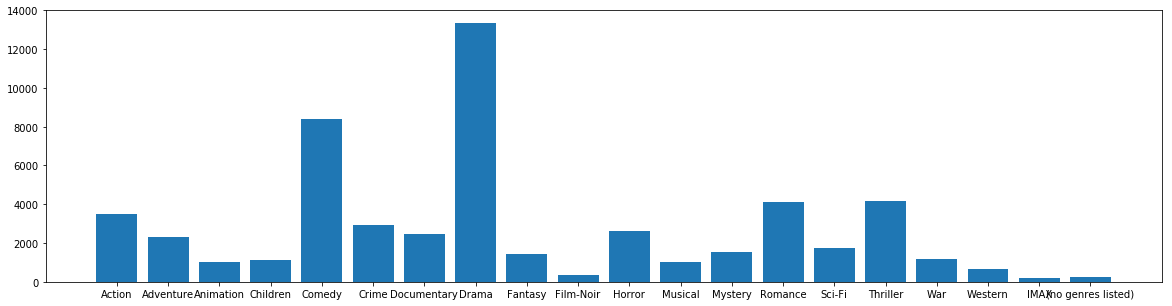

In [13]:
# CORRECTION FROM DOCUMENTATION - No "Children's" genre, actually "Children"
# CORRECTION FROM DOCUMENTATION - Unaccounted genre: IMAX

genre_dict = { "Action": 0,
               "Adventure": 0,
               "Animation": 0,
               "Children": 0,
               "Comedy": 0,
               "Crime": 0,
               "Documentary": 0,
               "Drama": 0,
               "Fantasy": 0,
               "Film-Noir": 0,
               "Horror": 0,
               "Musical": 0,
               "Mystery": 0,
               "Romance": 0,
               "Sci-Fi": 0,
               "Thriller": 0,
               "War": 0,
               "Western": 0,
               "IMAX": 0,
               "(no genres listed)": 0
             }

for row in df_movies.iterrows():
    for genre in row[1]["Genres"]:
        genre_dict[genre] = genre_dict[genre] + 1
        
#for genre, count in genre_dict.items(): 
#    print(genre, ":", count) 

plt.figure(figsize=(20,5))
plt.bar(range(len(genre_dict)), list(genre_dict.values()), align='center')
plt.xticks(range(len(genre_dict)), list(genre_dict.keys()))
plt.show()

## Data very heavy towards Drama and Comedy

1. Want to combine tags along with genre when considering movies, but want to make sure the tag is relevant to the given movie
2. Correlate tagId to movieId when relevance threshold is reached.  From there, use tagId to pull actual tag text and add to list in a new column

In [14]:
# Get some quick stats of the relevance values in the tags dataframe to know where to cut off

print("Max: ", max(df_gscores['relevance']))
print("Min: ", min(df_gscores['relevance']))
print("Avg: ", sum(df_gscores['relevance']) / len(df_gscores['relevance']))

Max:  1.0
Min:  0.00024999999999997247
Avg:  0.11648331730393226


In [15]:
# Don't care about values less than 0.25, so let's drop those from the dataframe
print(df_gscores.shape)
df_gscores = df_gscores[df_gscores.relevance >= 0.25]
print(df_gscores.shape)
df_gscores.head()

(11709768, 3)
(1510567, 3)


,movieId,tagId,relevance
7,1,8,0.26275
8,1,9,0.26200
10,1,11,0.57700
15,1,16,0.28175
18,1,19,0.67050


In [16]:
# Cut some more, only care about > 0.8

print(df_gscores.shape)
df_gscores = df_gscores[df_gscores.relevance >= 0.8]
print(df_gscores.shape)
df_gscores.head()

(1510567, 3)
(103052, 3)


,movieId,tagId,relevance
28,1,29,0.89200
62,1,63,0.93325
63,1,64,0.98575
185,1,186,0.95650
192,1,193,0.81925


## NOTE: By removing the year portion of the df_movies dataframe originally, I created an issue with dictionaries because there are some movie remakes that create an issue.  Will incorporate the year back into the title as well, but keep the year column separate still.

In [17]:
print(len(df_movies['Title'].unique()))
print(len(df_movies['Title']))

27262
27278


### Even when trying to keep movie title unique according to title+year, still having duplicate values.  Will remove these rows and continue on.

In [18]:
print(df_movies.shape)
df_movies = df_movies.drop_duplicates(subset="Title")
print(df_movies.shape)

(27278, 5)
(27262, 5)


In [19]:

# Collect a list of tags and relevance value for a given movie

movie_tags = []
rel_tagIds = []
rel_tags = []

for movie in df_movies.iterrows(): # movieId, Year, Title, Genres
    rel_tagIds = df_gscores[df_gscores.movieId == movie[1]['movieId']]
    tags = []
    for tag_list in rel_tagIds.iterrows():
        rel_tags.append(df_gtags[df_gtags.tagId == tag_list[1]['tagId']].tag.values)
    for item in rel_tags:
        tags.append(item[0])
    movie_tags.append(tags)
    #print(tags)
    tags = []

    
tags_list = pd.Series(movie_tags)
df_movies.insert(len(df_movies.columns), 'RelTags', tags_list, True)


## Dealing with tags being more of a headache than it's worth for the dataset, going to proceed with clustering based on year and genre list, but have tags in their string form

In [20]:
df_movies.head()

,movieId,Year,Title,Genres,GenreCodes,RelTags
0,1,1995,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]","[2, 3, 4, 5, 9]","[adventure, animated, animation, cartoon, cgi,..."
1,2,1995,Jumanji (1995),"[Adventure, Children, Fantasy]","[2, 4, 9]","[adventure, animated, animation, cartoon, cgi,..."
2,3,1995,Grumpier Old Men (1995),"[Comedy, Romance]","[5, 14]","[adventure, animated, animation, cartoon, cgi,..."
3,4,1995,Waiting to Exhale (1995),"[Comedy, Drama, Romance]","[5, 8, 14]","[adventure, animated, animation, cartoon, cgi,..."
4,5,1995,Father of the Bride Part II (1995),[Comedy],[5],"[adventure, animated, animation, cartoon, cgi,..."


In [21]:
df_movies.to_csv("../data/processed/movies_processed.csv")